In [17]:
# import torch
# import torchvision
# import numpy as np
# from torchvision.models import resnet18, ResNet18_Weights

# resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)
# The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. 
# You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
# print(resnet_model)
# # This method remove the layers upto to the convolution feature maps
# modules = list(resnet_model.children())[:-2]
# backbone = torch.nn.Sequential(*modules)
# print(backbone)

## Version 1 of the NaviNet


## Version 2 of NaviNet

## Version 3 of Navinet 

file_path="/home/foxy_user/foxy_ws/src/gail_navigation/GailNavigationNetwork/data/traj1.hdf5"
read_file= h5py.File(file_path, "r")
rgb_image=np.expand_dims((read_file['images']['rgb_data'][0]).reshape(3,240,320),axis=0)
rgb_image = torch.tensor(rgb_image,dtype=torch.float32) # Example shape, adjust as needed
depth_image=np.expand_dims((read_file['images']['depth_data'][0]).reshape(240,320),axis=0)
# depth_image=(read_file['images']['depth_data'][0])

depth_image = torch.tensor(depth_image,dtype=torch.float32)  # Example shape, adjust as needed
goal_pose=np.expand_dims(read_file['kris_dynamics']['odom_data']['target_vector'][0],axis=0)
goal_pose = torch.tensor(goal_pose,dtype=torch.float32)  # Example shape
actions=np.expand_dims(read_file['kris_dynamics']['odom_data']['odom_data_filtered'][0],axis=0)
actions= torch.tensor(actions,dtype=torch.float32)  # Example shape
print(f"rgb_image: {rgb_image.shape} and depth_image: {depth_image.shape} \
      goal_pose: {goal_pose.shape} and actions: {actions.shape} \n \n")
model= NaviNet()
rgb_features,depth_features = model(rgb_image, depth_image)




## Version 4 of NaviNet

In [18]:
import torch
from torch.nn import Conv2d, Linear,Parameter
from torch.nn import Module
from torchvision.models import efficientnet_b1,EfficientNet_B1_Weights
from kris_envs.wrappers.utilities import  transform_to_int8,preprocess_target,scale_arrays
from GailNavigationNetwork.utilities import preprocess
import numpy as np
import h5py



class RGBNet(Module):
    def __init__(self,ablation_depth=2):
        super().__init__()
        resnet_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V2)
        modules = list(resnet_model.children())[:-ablation_depth]
        self.backbone = torch.nn.Sequential(*modules)

    def forward(self, x):
        x = self.backbone(x)
        return x

class DepthNet(Module):
    def __init__(self):
        super().__init__()
        self.filter = Conv2d(in_channels=1, out_channels=2, kernel_size=3, 
                             stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = Parameter(G, requires_grad=False)
        self.fc=Linear(238*318,1280)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        

        return x
    
class TargetNet(Module):
    def __init__(self,in_channels, intermediate_channels, output_size):
        super().__init__()
        # self.fc = Linear(7,128)
        self.fc1 = Linear(in_channels, intermediate_channels)
        
        # Define the second fully connected layer
        self.fc2 = Linear(intermediate_channels, output_size)
        
    def forward(self,x):
        # x = self.fc(goal)
        x = self.fc1(x)
        x = torch.tanh(x)
        
        # Apply the second fully connected layer to get the final output
        x = self.fc2(x)
        return x

class NaviNet(Module):
    '''
    A deeplearning architecture for local navigation planning
    '''
    def __init__(self,
                 image_dims=(240,320),
                 goal_dims=7):
         super(NaviNet, self).__init__()
         self.depth_net = DepthNet()
         self.rgb_net = RGBNet(ablation_depth=1)
         self.target_net=TargetNet(goal_dims,640,1280)
        #  self.fc_goal_pose = Linear(goal_dims, 128)   

    def forward(self,rgb_image, depth_image,target):      
        rgb_features = self.rgb_net(rgb_image).squeeze()
        depth_features = self.depth_net(depth_image).squeeze()
        taget_features = self.target_net(target)
        return (rgb_features, depth_features,taget_features)

In [19]:
file_path="/home/foxy_user/foxy_ws/src/gail_navigation/GailNavigationNetwork/data/trajectories/expert/easy_world/traj1.hdf5"
image_index=10
DEVICE="cuda"
model= NaviNet().to(DEVICE)
read_file= h5py.File(file_path, "r")
batch_size=read_file['kris_dynamics']['odom_data']['target_vector'].shape[0]
rgb_features, depth_features,target_features = [],[],[]
for i in range(batch_size):
    rgb=read_file['images']['rgb_data'][i]
    depth=read_file['images']['depth_data'][i]
    target=read_file['kris_dynamics']['odom_data']['target_vector'][i]

    # Normalise action to -1 to 1
    rgb=preprocess(rgb)
    # Convert depth to int8
    depth=transform_to_int8(depth)
    depth=preprocess(depth)
    target=preprocess_target(target)



    (rgb, depth,target) = (rgb.to(DEVICE),depth.to(DEVICE),target.to(DEVICE))
    rgb_feature, depth_feature,target_feature= model(rgb,depth,target)
    #Detach the tensors and convert to numpy arrays and scale the arrays
    rgb_feature=rgb_feature.detach().cpu().numpy()
    rgb_feature=scale_arrays(rgb_feature)
    depth_feature=depth_feature.detach().cpu().numpy()
    depth_feature=scale_arrays(depth_feature)
    target_feature=target_feature.detach().cpu().numpy()
    target_feature=scale_arrays(target_feature)
    # rgb_features.append(rgb_feature)
    # depth_features.append(depth_feature)
    # target_features.append(target_feature)

    rgb_features.extend(rgb_feature)
    depth_features.extend(depth_feature)
    target_features.extend(target_feature)

print(f"rgb_features: {len(rgb_features)} \n depth_features: {len(depth_features)} \n target features {len(target_features)} \n \n")

rgb_features: 83200 
 depth_features: 83200 
 target features 83200 
 



mean1: -0.027732430025935173 median1: -0.025984078645706177 std_dev1: 0.32668057084083557 

mean2: 0.05104568600654602 median2: 0.050878942012786865 std_dev2: 0.31164976954460144 

mean3: -0.03222837671637535 median3: -0.03217330574989319 std_dev3: 0.3133883476257324 

First print done
Second print done
Third print done
Fourth print done


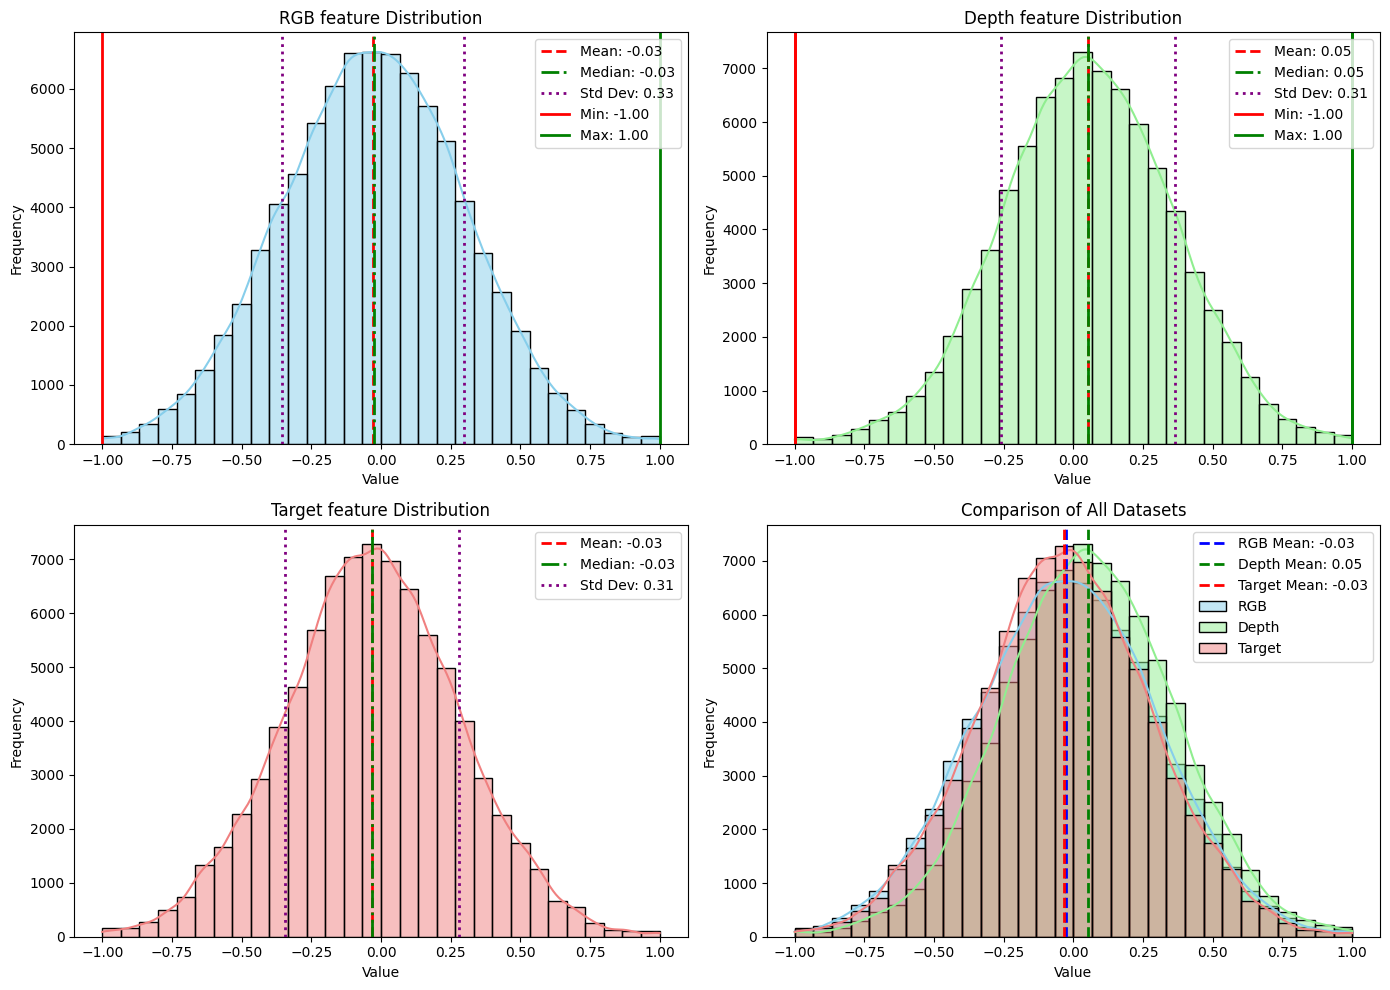

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate sample datasets
data1 = rgb_features
data2 = depth_features
data3 = target_features

# Calculate important statistics
mean1, median1, std_dev1 , min1, max1 = np.mean(data1), np.median(data1), np.std(data1) , np.min(data1), np.max(data1)
mean2, median2, std_dev2 , min2 , max2 = np.mean(data2), np.median(data2), np.std(data2) , np.min(data2), np.max(data2)
mean3, median3, std_dev3, min3 ,max3 = np.mean(data3), np.median(data3), np.std(data3), np.min(data3), np.max(data3)


print(f"mean1: {mean1} median1: {median1} std_dev1: {std_dev1} \n")
print(f"mean2: {mean2} median2: {median2} std_dev2: {std_dev2} \n")
print(f"mean3: {mean3} median3: {median3} std_dev3: {std_dev3} \n")
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))



# Plot dataset 1
sns.histplot(data1, kde=True, bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].axvline(mean1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean1:.2f}')
axes[0, 0].axvline(median1, color='green', linestyle='-.', linewidth=2, label=f'Median: {median1:.2f}')
axes[0, 0].axvline(mean1 + std_dev1, color='purple', linestyle=':', linewidth=2, label=f'Std Dev: {std_dev1:.2f}')
axes[0, 0].axvline(mean1 - std_dev1, color='purple', linestyle=':', linewidth=2)
axes[0, 0].axvline(min1, color='red', linestyle='-', linewidth=2, label=f'Min: {min1:.2f}')
axes[0, 0].axvline(max1, color='green', linestyle='-', linewidth=2, label=f'Max: {max1:.2f}')
axes[0, 0].legend()
axes[0, 0].set_title('RGB feature Distribution')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
print(f"First print done")

# Plot dataset 2
sns.histplot(data2, kde=True, bins=30, color='lightgreen', ax=axes[0, 1])
axes[0, 1].axvline(mean2, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean2:.2f}')
axes[0, 1].axvline(median2, color='green', linestyle='-.', linewidth=2, label=f'Median: {median2:.2f}')
axes[0, 1].axvline(mean2 + std_dev2, color='purple', linestyle=':', linewidth=2, label=f'Std Dev: {std_dev2:.2f}')
axes[0, 1].axvline(mean2 - std_dev2, color='purple', linestyle=':', linewidth=2)
axes[0, 1].axvline(min1, color='red', linestyle='-', linewidth=2, label=f'Min: {min2:.2f}')
axes[0, 1].axvline(max1, color='green', linestyle='-', linewidth=2, label=f'Max: {max2:.2f}')
axes[0, 1].legend()
axes[0, 1].set_title('Depth feature Distribution')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
print(f"Second print done")

# Plot dataset 3
sns.histplot(data3, kde=True, bins=30, color='lightcoral', ax=axes[1, 0])
axes[1, 0].axvline(mean3, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean3:.2f}')
axes[1, 0].axvline(median3, color='green', linestyle='-.', linewidth=2, label=f'Median: {median3:.2f}')
axes[1, 0].axvline(mean3 + std_dev3, color='purple', linestyle=':', linewidth=2, label=f'Std Dev: {std_dev3:.2f}')
axes[1, 0].axvline(mean3 - std_dev3, color='purple', linestyle=':', linewidth=2)
axes[0, 1].axvline(min1, color='red', linestyle='-', linewidth=2, label=f'Min: {min3:.2f}')
axes[0, 1].axvline(max1, color='green', linestyle='-', linewidth=2, label=f'Max: {max3:.2f}')
axes[1, 0].legend()
axes[1, 0].set_title('Target feature Distribution')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
print(f"Third print done")

# Plot all datasets together for comparison
sns.histplot(data1, kde=True, bins=30, color='skyblue', label='RGB', ax=axes[1, 1])
sns.histplot(data2, kde=True, bins=30, color='lightgreen', label='Depth', ax=axes[1, 1])
sns.histplot(data3, kde=True, bins=30, color='lightcoral', label='Target', ax=axes[1, 1])
axes[1, 1].axvline(mean1, color='blue', linestyle='--', linewidth=2, label=f'RGB Mean: {mean1:.2f}')
axes[1, 1].axvline(mean2, color='green', linestyle='--', linewidth=2, label=f'Depth Mean: {mean2:.2f}')
axes[1, 1].axvline(mean3, color='red', linestyle='--', linewidth=2, label=f'Target Mean: {mean3:.2f}')
axes[1, 1].legend()
axes[1, 1].set_title('Comparison of All Datasets')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')
print(f"Fourth print done")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
